In [2]:
import string
import pandas as pd
import re
import numpy as np

from tqdm import tqdm
tqdm.pandas()

import spacy
nlp = spacy.load('en_core_web_sm')

In [42]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
from sklearn.model_selection import train_test_split

---

### 1)

### Loading in the data and doing an EDA

In [5]:
data_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Final_Project/The_Office_lines.csv')
data_raw.head(5)

,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


In [6]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59909 entries, 0 to 59908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         59909 non-null  int64 
 1   season     59909 non-null  int64 
 2   episode    59909 non-null  int64 
 3   scene      59909 non-null  int64 
 4   line_text  59909 non-null  object
 5   speaker    59909 non-null  object
 6   deleted    59909 non-null  bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 2.8+ MB


<Axes: title={'center': 'lines per character (20 most frequent speakers)'}, xlabel='character', ylabel='# of lines'>

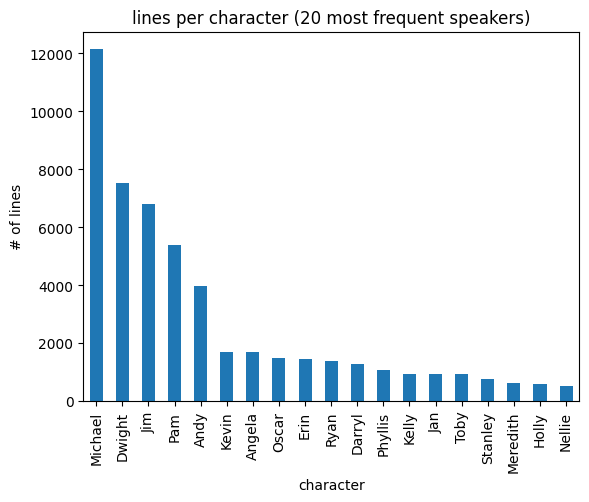

In [7]:
data_raw['speaker'].value_counts()[:19].plot(kind = 'bar',
                                         title = 'lines per character (20 most frequent speakers)',
                                         xlabel = 'character',
                                         ylabel = '# of lines')

<Axes: title={'center': 'lines per season'}, xlabel='season', ylabel='# of lines'>

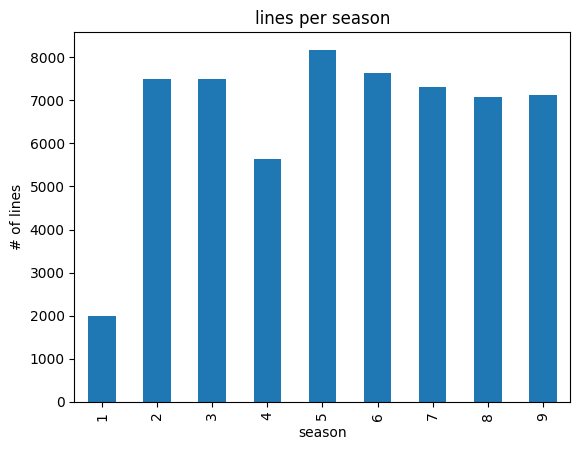

In [8]:
data_raw['season'].value_counts(sort = False)[:19].plot(kind = 'bar',
                                         title = 'lines per season',
                                         xlabel = 'season',
                                         ylabel = '# of lines')

In [9]:
all_lines = list(data_raw['line_text'])

In [10]:
def remove_directions(line):
  return re.sub('\[.*?\]','', line)

In [11]:
for i in range(len(all_lines)):
  all_lines[i] = remove_directions(all_lines[i])
  all_lines[i] = all_lines[i].lower().replace('.', '').translate(str.maketrans('', '', string.punctuation)).strip()

In [12]:
all_lines[:5]

['all right jim your quarterlies look very good how are things at the library',
 'oh i told you i couldnt close it so',
 'so youve come to the master for guidance is this what youre saying grasshopper',
 'actually you called me in here but yeah',
 'all right well let me show you how its done']

In [13]:
clean_data = pd.DataFrame(data = {'speaker':data_raw['speaker'], 'line':all_lines})

In [14]:
clean_data

,speaker,line
0,Michael,all right jim your quarterlies look very good ...
1,Jim,oh i told you i couldnt close it so
2,Michael,so youve come to the master for guidance is th...
3,Jim,actually you called me in here but yeah
4,Michael,all right well let me show you how its done
...,...,...
59904,Creed,it all seems so very arbitrary i applied for a...
59905,Meredith,i just feel lucky that i got a chance to share...
59906,Phyllis,im happy that this was all filmed so i can rem...
59907,Jim,i sold paper at this company for 12 years my j...


In [15]:
len(clean_data['speaker'].unique())
# there are a lot of characters who have only a few lines and
# will not be enough for the model to learn, so I am only going to focus on the 20 most frequent speakers.

784

In [16]:
freq_speakers = list(clean_data['speaker'].value_counts().iloc[:5].keys())

In [17]:
trim_data = clean_data[clean_data['speaker'].isin(freq_speakers)]

In [18]:
trim_data

,speaker,line
0,Michael,all right jim your quarterlies look very good ...
1,Jim,oh i told you i couldnt close it so
2,Michael,so youve come to the master for guidance is th...
3,Jim,actually you called me in here but yeah
4,Michael,all right well let me show you how its done
...,...,...
59885,Andy,i spent so much of my time here at dunder miff...
59889,Jim,imagine going back and watching a tape of your...
59891,Jim,thanks phyl
59907,Jim,i sold paper at this company for 12 years my j...


### TF-IDF

In [19]:
clean_copy = clean_data.copy()

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
vectorizer = TfidfVectorizer()

In [22]:
NLP = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [23]:
clean_copy['tokens'] = clean_copy['line'].progress_apply(lambda x: [x.lemma_.lower() for x in NLP(x) if x.lemma_.lower()])

100%|██████████| 59909/59909 [03:13<00:00, 309.32it/s]


In [24]:
token_copy = clean_copy.copy()

In [25]:
tokens = (token_copy.explode('tokens'))

In [26]:
tokens.reset_index(drop = False, inplace = True)

In [27]:
tokens

,index,speaker,line,tokens
0,0,Michael,all right jim your quarterlies look very good ...,all
1,0,Michael,all right jim your quarterlies look very good ...,right
2,0,Michael,all right jim your quarterlies look very good ...,jim
3,0,Michael,all right jim your quarterlies look very good ...,your
4,0,Michael,all right jim your quarterlies look very good ...,quarterly
...,...,...,...,...
664224,59908,Pam,i thought it was weird when you picked us to m...,that
664225,59908,Pam,i thought it was weird when you picked us to m...,kind
664226,59908,Pam,i thought it was weird when you picked us to m...,of
664227,59908,Pam,i thought it was weird when you picked us to m...,the


In [28]:
term_frequency = (tokens
                  .groupby(by=['index', 'tokens'])
                  .agg({'tokens': 'count'})
                  .rename(columns={'tokens': 'term_frequency'})
                  .reset_index()
                  .rename(columns={'tokens': 'term'})
                 )

In [29]:
term_frequency['term'] = term_frequency['term'].str.strip()

In [30]:
term_frequency.sort_values(by = 'term_frequency', inplace = True)

In [31]:
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
         'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
         'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
         'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
         'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
         'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 've', 'll', 'amp']

In [32]:
# remove stop words
term_frequency = term_frequency.drop(term_frequency[term_frequency['term'].isin(stop_words)].index)
term_frequency.head(3)

,index,term,term_frequency
367178,39242,cure,1
367174,39241,think,1
367172,39241,michael,1


In [33]:
tfidf_matrix = vectorizer.fit_transform(data_raw['line_text'])

In [34]:
feature_names = vectorizer.get_feature_names_out()

In [35]:
print(tfidf_matrix.toarray())
print(feature_names)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['00' '000' '0000' ... 'zuckerberg' 'zuckerberged' 'zwarte']


# Neural Network with 5 Most Freq Speakers (Michael, Jim, Pam, Andy, Dwight)

In [ ]:
from sklearn.model_selection import cross_validate

In [36]:
quotes = list(trim_data['line'])
characters = list(trim_data['speaker'])

In [ ]:
len(characters)

35835

In [ ]:
stop_words = ['i','im','thats','didnt','id','couldnt','wouldnt','dont','wont','cant', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
         'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
         'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
         'while', 'wasnt', 'its', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
         'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
         'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 've', 'll', 'amp']

In [ ]:
quote_split = [quote.split() for quote in quotes]

In [ ]:
quote_split_rem_sw = []
for i in range(len(quote_split)):
  quote_split_rem_sw.append([word for word in quote_split[i] if word not in stop_words])

In [ ]:
clean_quotes = quote_split_rem_sw.copy()
for i in range(len(quote_split_rem_sw)):
  clean_quotes[i] = ' '.join(quote_split_rem_sw[i])

In [ ]:
quotes

In [37]:
# Example data (quotes and corresponding character labels)
#quotes = clean_quotes
characters = list(trim_data['speaker'])

# Convert characters to numerical labels
label_map = {char: idx for idx, char in enumerate(set(characters))}
labels = np.array([label_map[char] for char in characters])

# tokenizing and padding
max_len = max(len(quote.split()) for quote in quotes) # finding the max_len of all quotes to pad the rest with zeroes to that length
vocab_size = 50000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(quotes)
sequences = tokenizer.texts_to_sequences(quotes)
X = pad_sequences(sequences, maxlen=max_len)



In [ ]:
label_map

{'Michael': 0, 'Jim': 1, 'Dwight': 2, 'Andy': 3, 'Pam': 4}

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=123, shuffle = True)

In [56]:
from tensorflow.keras.utils import to_categorical

In [86]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_len))
model.add(Bidirectional(LSTM(128)))  # Bidirectional LSTM layer
model.add(Dense(32))
model.add(Dropout(rate = .4))
model.add(Dense(5, activation = 'softmax'))
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [87]:
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.3)

Epoch 1/10
314/314 [==============================] - 39s 113ms/step - loss: 1.5270 - accuracy: 0.3367 - val_loss: 1.4816 - val_accuracy: 0.3624
Epoch 2/10
314/314 [==============================] - 15s 46ms/step - loss: 1.4063 - accuracy: 0.4106 - val_loss: 1.4440 - val_accuracy: 0.3823
Epoch 3/10
314/314 [==============================] - 12s 40ms/step - loss: 1.2188 - accuracy: 0.5041 - val_loss: 1.5138 - val_accuracy: 0.3780
Epoch 4/10
314/314 [==============================] - 11s 35ms/step - loss: 1.0633 - accuracy: 0.5712 - val_loss: 1.5981 - val_accuracy: 0.3596
Epoch 5/10
314/314 [==============================] - 12s 37ms/step - loss: 0.9473 - accuracy: 0.6211 - val_loss: 1.6900 - val_accuracy: 0.3614
Epoch 6/10
314/314 [==============================] - 10s 32ms/step - loss: 0.8703 - accuracy: 0.6412 - val_loss: 1.8122 - val_accuracy: 0.3651
Epoch 7/10
314/314 [==============================] - 10s 33ms/step - loss: 0.8159 - accuracy: 0.6634 - val_loss: 1.9127 - val_accuracy

In [88]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

224/224 [==============================] - 2s 9ms/step - loss: 2.2114 - accuracy: 0.3492
Test Loss: 2.2114474773406982
Test Accuracy: 0.3492395579814911


## K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold

In [39]:
from tensorflow.keras import layers

In [ ]:
kfold = KFold(n_splits = 6, shuffle = True)

In [ ]:
text_vectorizer = layers.TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=100)
text_vectorizer.adapt(texts)

In [ ]:
acc_scores = []
loss_scores = []

for train_idx, val_idx in kfold.split(X_train, y_train):

    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = Sequential()
    model.add(Embedding(vocab_size, 32, input_length=max_len))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(rate = .05))
    model.add(Dense(64, activation='softmax'))
    model.add(Dropout(rate = .05))
    model.add(Dense(5), activation = 'softmax')

    # compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=64, validation_split=0.2)

    loss, acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    acc_scores.append(acc)
    loss_scores.append(loss)

Epoch 1/10
287/287 [==============================] - 26s 75ms/step - loss: 2.3140 - accuracy: 0.3111 - val_loss: 1.5473 - val_accuracy: 0.3423
Epoch 2/10
287/287 [==============================] - 8s 28ms/step - loss: 2.1728 - accuracy: 0.3408 - val_loss: 1.5501 - val_accuracy: 0.3141
Epoch 3/10
287/287 [==============================] - 6s 21ms/step - loss: 2.0659 - accuracy: 0.4119 - val_loss: 1.5242 - val_accuracy: 0.3488
Epoch 4/10
287/287 [==============================] - 6s 22ms/step - loss: 1.9207 - accuracy: 0.4873 - val_loss: 1.6196 - val_accuracy: 0.3643
Epoch 5/10
287/287 [==============================] - 6s 20ms/step - loss: 1.7524 - accuracy: 0.5487 - val_loss: 1.6696 - val_accuracy: 0.3615
Epoch 6/10
287/287 [==============================] - 5s 18ms/step - loss: 1.6881 - accuracy: 0.5750 - val_loss: 1.8036 - val_accuracy: 0.3527
Epoch 7/10
287/287 [==============================] - 6s 21ms/step - loss: 1.5441 - accuracy: 0.5988 - val_loss: 1.9345 - val_accuracy: 0.346

In [ ]:
np.mean(acc_scores)

0.33626394867897036

# RNN

In [ ]:
labels

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Assuming you have a list of texts and corresponding labels
texts = clean_quotes
labels = ...

# Define the text vectorization layer
text_vectorizer = layers.TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=100)
text_vectorizer.adapt(texts)

# Define the RNN model
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()), output_dim=128, mask_zero=True),
    layers.LSTM(64),  # LSTM layer with 64 units
    layers.Dense(64, activation='relu'),
    layers.Dense(len(set(labels)), activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(texts, labels, epochs=10, validation_split=0.2)

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
num_tokens = len(tokenizer.word_index) + 1 # add 1 for padding
embedding_dim = 128
num_classes = len(tag_tokenizer.word_index) + 1 # add 1 for padding
tf.random.set_seed(42)

model = keras.Sequential()

model.add(layers.Embedding(input_dim=num_tokens,
                           output_dim=embedding_dim,
                           input_length=MAX_LEN,
                           mask_zero=True))

model.add(
    layers.Bidirectional(
        layers.LSTM(128,
                    return_sequences=True,
                    kernel_initializer=tf.keras.initializers.random_normal(seed=42)
                    )
        )
    )

model.add(layers.Dense(num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.random_normal(seed=42)))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Take 2

In [ ]:
# Example data (quotes and corresponding character labels)
#quotes = clean_quotes
characters = list(trim_data['speaker'])

# Convert characters to numerical labels
label_map = {char: idx for idx, char in enumerate(set(characters))}
labels = np.array([label_map[char] for char in characters])

# tokenizing and padding
max_len = max(len(quote.split()) for quote in quotes) # finding the max_len of all quotes to pad the rest with zeroes to that length
vocab_size = 50000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(quotes)
sequences = tokenizer.texts_to_sequences(quotes)
X = pad_sequences(sequences, maxlen=max_len)

In [ ]:
label_map

{'Andy': 0, 'Michael': 1, 'Dwight': 2, 'Pam': 3, 'Jim': 4}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=123, shuffle = True)

In [ ]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=max_len))
model.add(Bidirectional(LSTM(128)))  # Bidirectional LSTM layer
model.add(Dense(64, activation='softmax'))
model.add(Dropout(rate = .12))
model.add(Dense(5, activation = 'softmax'))

# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

NameError: name 'Sequential' is not defined

In [ ]:
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.3)

Epoch 1/10
  72/1255 [>.............................] - ETA: 3:03 - loss: 1.5775 - accuracy: 0.3134

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

224/224 [==============================] - 4s 18ms/step - loss: 1.6696 - accuracy: 0.3579
Test Loss: 1.6696497201919556
Test Accuracy: 0.3578903377056122
